In [20]:
import pandas as pd
import numpy as np 

from gensim import corpora
from gensim.models import LsiModel, CoherenceModel
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
from gensim.matutils import corpus2dense, corpus2csc

import matplotlib.pyplot as plt

from wordcloud import WordCloud

import pyLDAvis
import pyLDAvis.lda_model

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer


## Latent Sematic Analysis (LSA)

In [8]:
data = pd.read_csv("data/preprocessed.csv")
data_spotify = pd.read_csv("data/preprocessed_spotify.csv")
X = data['clean_lyrics'].apply(str.split)

# Create a dictionary and a corpus
dictionary = corpora.Dictionary(X)
dictionary.filter_extremes(no_below= 0.01, no_above= 0.75)

corpus = [dictionary.doc2bow(doc) for doc in X]

# Perform LSA
lsa_model = LsiModel(corpus, id2word=dictionary, num_topics= 8)

# Print the topics
topics = lsa_model.print_topics(num_words=4)
for topic in topics:
    print(topic)



c:\Users\garim\anaconda3\envs\github\lib\site-packages\gensim\models\lsimodel.py:963: DeprecationWarning: `scipy.sparse.sparsetools.csc_matvecs` is deprecated along with the `scipy.sparse.sparsetools` namespace. `scipy.sparse.sparsetools.csc_matvecs` will be removed in SciPy 1.14.0, and the `scipy.sparse.sparsetools` namespace will be removed in SciPy 2.0.0.
  sparsetools.csc_matvecs(
c:\Users\garim\anaconda3\envs\github\lib\site-packages\scipy\linalg\_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape[0], m.shape[1], k - 1, m.dtype.char)) * m
c:\Users\garim\anaconda3\envs\github\lib\site-packages\scipy\linalg\_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape[0], m.shape[1], k - 1, m.dtype.char)) 

(0, '0.402*"say" + 0.220*"go" + 0.198*"wa" + 0.191*"tell"')
(1, '0.637*"wa" + -0.221*"say" + 0.202*"de" + 0.200*"one"')
(2, '-0.319*"thou" + -0.289*"king" + -0.262*"thee" + -0.259*"said"')
(3, '0.432*"bloom" + 0.271*"bruce" + -0.181*"say" + 0.170*"back"')
(4, '0.523*"bloom" + -0.241*"bruce" + -0.211*"na" + 0.194*"stephen"')
(5, '0.366*"bruce" + -0.284*"na" + -0.278*"love" + -0.224*"im"')
(6, '-0.689*"feat" + 0.231*"bond" + -0.226*"love" + 0.120*"na"')
(7, '-0.579*"bond" + -0.311*"lawrence" + -0.263*"feat" + -0.246*"natalya"')


c:\Users\garim\anaconda3\envs\github\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\garim\anaconda3\envs\github\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
c:\Users\garim\anaconda3\envs\github\lib\site-packages\IPython\core\pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


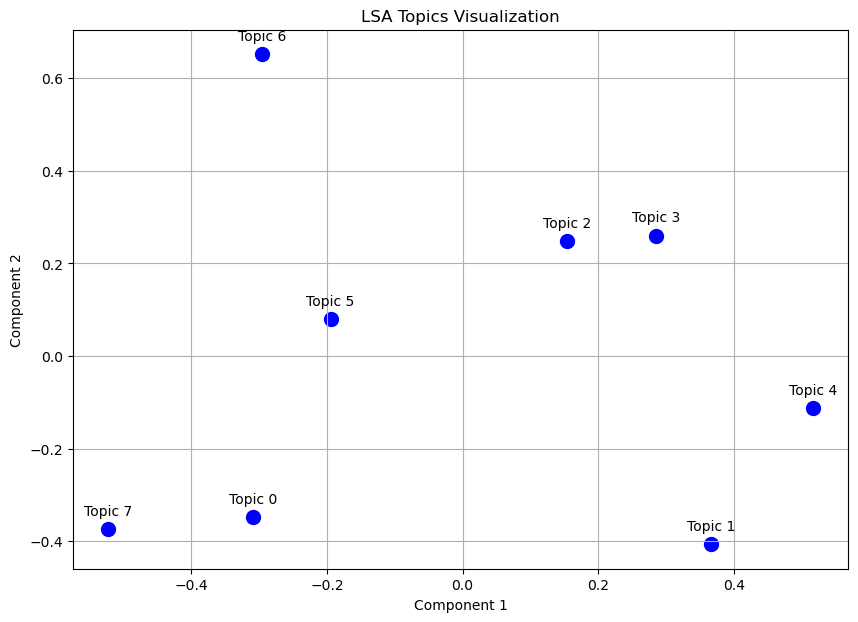

In [9]:
# Get topic vectors
topics = lsa_model.get_topics()  # Shape: (num_topics, num_words)

# Reduce dimensionality
def reduce_dimensionality(vectors, method='tsne'):
    if method == 'pca':
        reducer = PCA(n_components=2)
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42)
    else:
        raise ValueError("Method must be 'pca' or 'tsne'")
    
    reduced_vectors = reducer.fit_transform(vectors)
    return reduced_vectors

reduced_topics = reduce_dimensionality(topics, method='pca')  # or 'pca'

# Plotting
def plot_topics(reduced_vectors, topic_names):
    plt.figure(figsize=(10, 7))
    plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], marker='o', c='blue', s=100)
    
    for i, name in enumerate(topic_names):
        plt.annotate(name, (reduced_vectors[i, 0], reduced_vectors[i, 1]),
                     textcoords="offset points", xytext=(0,10), ha='center')
    
    plt.title('LSA Topics Visualization')
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True)
    plt.show()

# Create topic names
topic_names = [f'Topic {i}' for i in range(lsa_model.num_topics)]

# Plot
plot_topics(reduced_topics, topic_names)

In [10]:
doc_topic = pd.DataFrame(corpus2csc(lsa_model[corpus]).toarray(), columns= data['Song ID']).T
doc_topic

,0,1,2,3,4,5,6,7
Song ID,,,,,,,,
0,3.540194,3.275555,-0.017383,0.404183,0.001038,-0.114516,0.876987,-0.375315
1,2.673546,0.394208,0.074934,1.916448,-0.999509,-0.383404,0.386528,-0.086830
2,2.484312,-0.126312,-0.142141,1.484683,-2.068368,-3.217105,-0.556264,0.856129
3,2.108798,0.369480,-0.023635,1.262595,-0.900191,-2.122943,-1.027534,0.210007
4,3.519742,-0.316087,0.518448,2.137428,-3.108009,-4.040051,-0.145723,0.599309
...,...,...,...,...,...,...,...,...
5496,9.855320,3.208437,0.890047,4.689193,-6.602892,-7.358048,3.055189,2.938278
5497,9.150772,2.618698,-0.404158,2.377531,-1.883065,-2.295178,0.549325,0.692442
5498,10.110887,1.239333,-0.132777,3.873247,-6.725061,-7.856964,2.844224,2.017741


In [11]:
# data['lsa_topic'] = doc_topic.idxmax(axis= 1)
# data['lsa_topic'].value_counts(normalize= True)

In [12]:
# pd.pivot_table(data, index= "Year", columns= "lsa_topic", 
#                values= "Song ID", aggfunc= "count").fillna(0).plot()

## Latent Dirichlet Allocation

In [26]:
# Define helper function to print and return top words
def get_topic_words(lda_model, feature_names, n_words=10, print_words= False):
    topic_words = {}
    for topic_idx, topic in enumerate(lda_model.components_):
        # words = [feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]
        # topic_words[f"Topic {topic_idx}"] = words

         # Get words and their weights
        word_weights = {feature_names[i]: topic[i] for i in range(len(feature_names))}
        # Sort words by their weights in descending order
        sorted_words = dict(sorted(word_weights.items(), key=lambda item: item[1], reverse=True))
        topic_words[f"Topic {topic_idx}"] = sorted_words

        # print if needed
        if print_words:
            message = "\nTopic # {}:".format(topic_idx)
            message += " ;".join([feature_names[i] for i in topic.argsort()[:-n_words - 1 :-1]])
            print(message)

    return topic_words

# Define a function to compute coherence score using gensim
def compute_coherence_score(lda_model, corpus, dictionary, feature_names):
    topics = []
    for topic_id in range(lda_model.n_components):
        topic_words = [feature_names[i] for i in np.argsort(lda_model.components_[topic_id])[::-1]]
        topics.append(topic_words)
    
    coherence_model = CoherenceModel(topics=topics, texts=corpus, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()
    return coherence_score

In [36]:
topics = []
for topic_id in range(lda.n_components):
    topic_words = [feature_names[i] for i in np.argsort(lda.components_[topic_id])[::-1]]
    topics.append(topic_words)

len(topics)

10

In [42]:
coherence_model = CoherenceModel(topics=topics, texts=corpus, dictionary=dictionary, coherence='c_v')
coherence_model.get_coherence()

0.3951999796522719

In [41]:
tfidf = TfidfVectorizer(min_df= 0.01, max_df= 0.4, ngram_range= (1,4))
X = tfidf.fit_transform(data_spotify['clean_lyrics'])
feature_names = tfidf.get_feature_names_out()


# Prepare data for coherence calculation
corpus = [text.split() for text in data_spotify['clean_lyrics']]
dictionary = Dictionary(corpus)

lda = LatentDirichletAllocation(n_components= 10)
doc_topic = lda.fit_transform(X)


Topic # 0:wan ;wan na ;na ;dance ;let ;get ;fire ;go ;want ;party ;music ;rock ;come ;higher ;got ;tonight ;dancing ;baby ;take ;night ;one ;move ;rhythm ;ride ;beat ;feel ;make ;together ;body ;burn

Topic # 1:got ;get ;nigga ;aint ;ya ;shit ;man ;bitch ;fuck ;em ;money ;cause ;go ;want ;back ;thats ;big ;one ;make ;let ;girl ;boy ;yo ;come ;see ;cant ;wa ;say ;take ;right

Topic # 2:lord ;god ;come ;wa ;sky ;night ;light ;jesus ;heart ;day ;life ;see ;sing ;sun ;one ;sea ;let ;wind ;world ;heaven ;eye ;king ;away ;river ;angel ;moon ;star ;soul ;fly ;song

Topic # 3:wa ;said ;got ;well ;man ;home ;back ;old ;one ;go ;time ;get ;night ;little ;never ;day ;girl ;town ;ive ;good ;way ;come ;boy ;could ;say ;see ;blue ;woman ;long ;aint

Topic # 4:na ;gon na ;gon ;im gon na ;im gon ;got ;hey ;ta ;got ta ;get ;go ;hey hey ;baby ;aint ;make ;want ;let ;take ;time ;come ;well ;cause ;na get ;gon na get ;right ;back ;na make ;ill ;say ;gon na make

Topic # 5:time ;life ;see ;world ;one ;tak

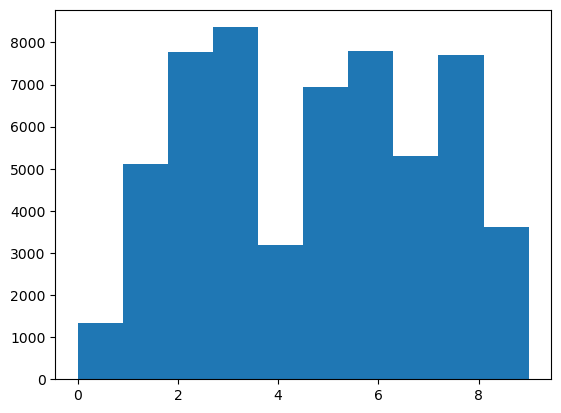

In [15]:
plt.hist(np.argmax(doc_topic, axis= 1));

topic_words = get_topic_words(lda, feature_names, n_words= 30, print_words= True);

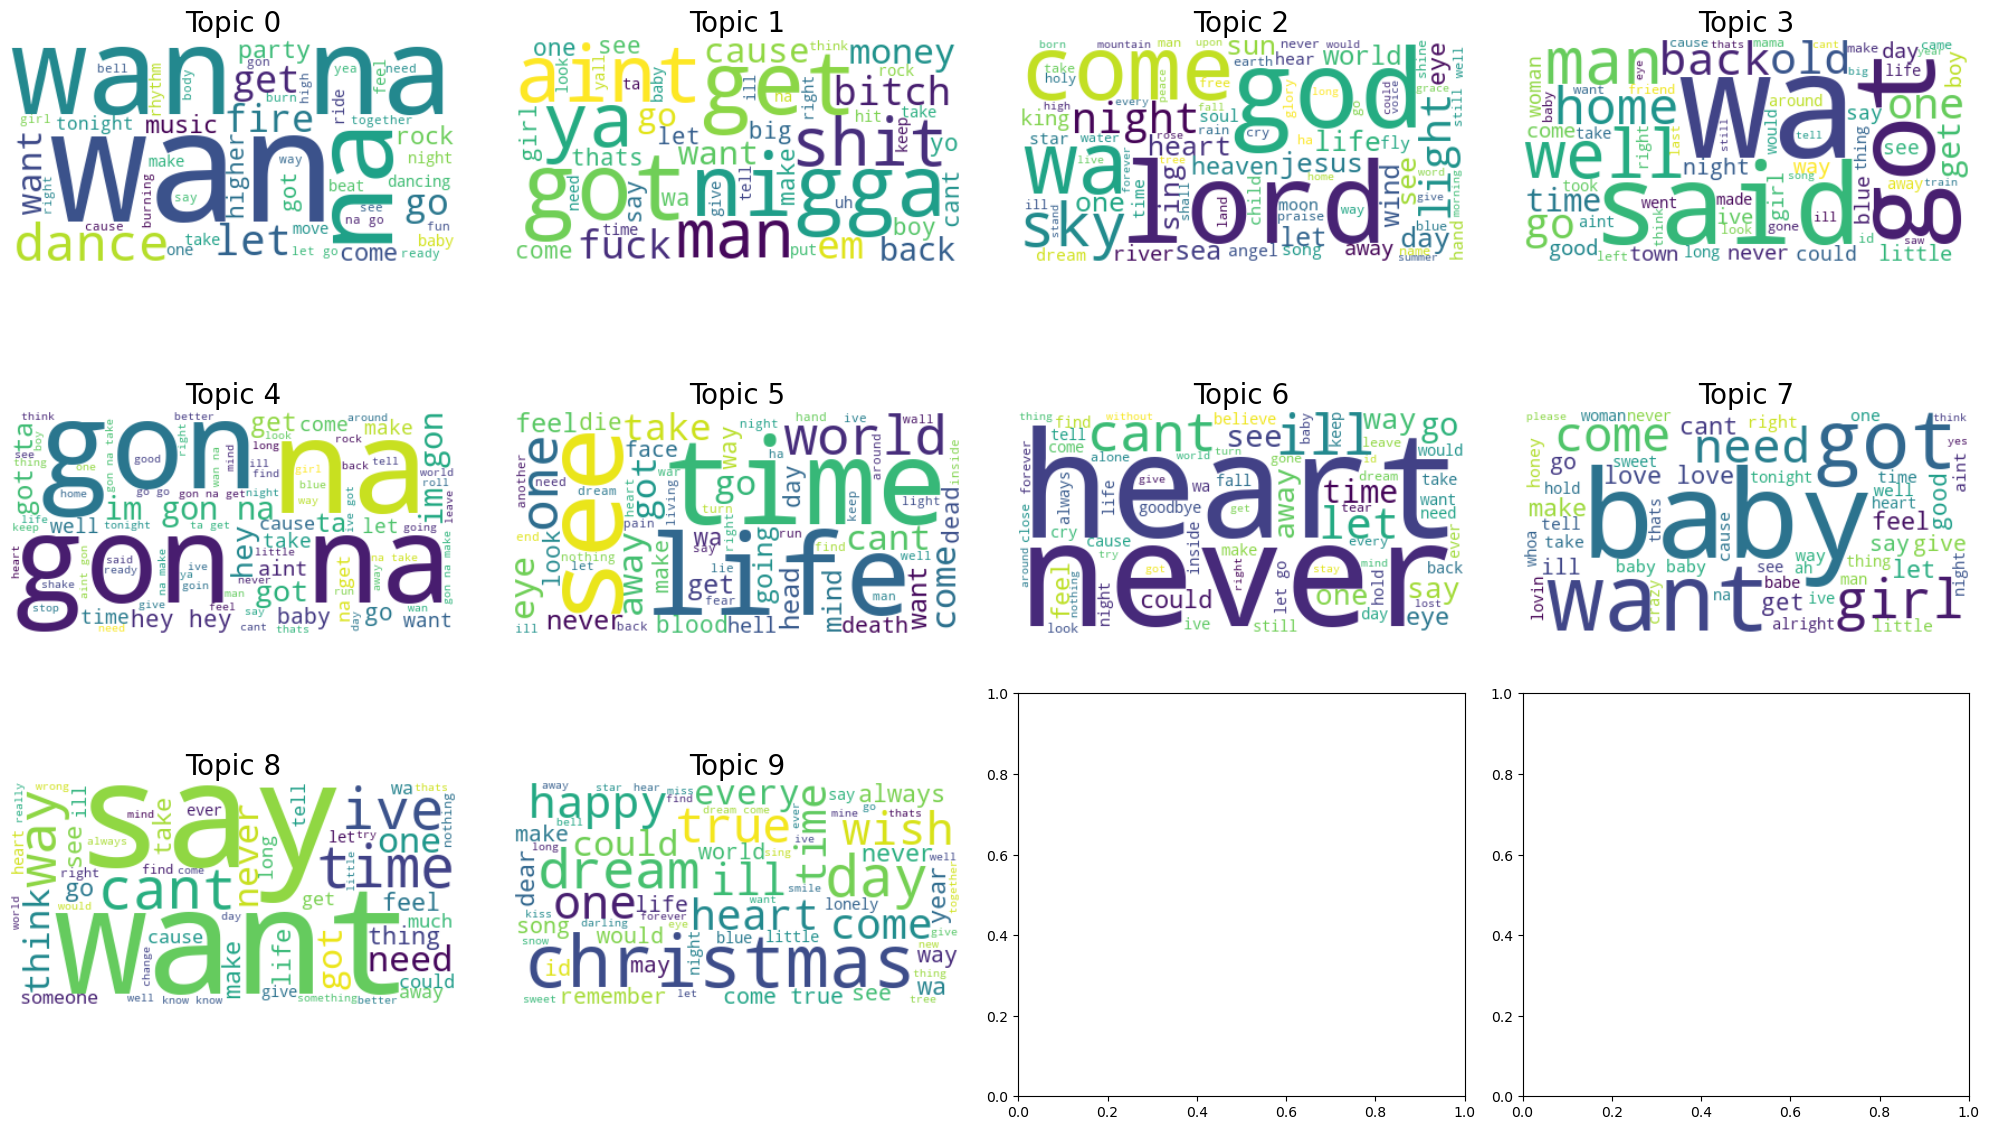

In [16]:
fig,axs = plt.subplots(figsize= (20,12), ncols= 4, nrows= int(np.ceil(lda.n_components/4)) )


def plot_wordcloud(words, title, ax):
    wordcloud = WordCloud(background_color='white', contour_color='steelblue', contour_width=1,
                          colormap='viridis', min_font_size= 10).generate_from_frequencies(words)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, fontsize= 20)
    ax.axis('off')

ii = 0; jj = 0
for topic, words in topic_words.items():
    plot_wordcloud(words, topic, axs[ii][jj])
    if jj == 3:
        jj = 0
        ii += 1
    else:
        jj += 1

plt.tight_layout();


In [27]:

# Compute Coherence Score
coherence_score = compute_coherence_score(lda, corpus, dictionary, feature_names)
coherence_score

c:\Users\garim\anaconda3\envs\github\lib\site-packages\gensim\topic_coherence\direct_confirmation_measure.py:204: RuntimeWarning: divide by zero encountered in scalar divide
  m_lr_i = np.log(numerator / denominator)
c:\Users\garim\anaconda3\envs\github\lib\site-packages\gensim\topic_coherence\indirect_confirmation_measure.py:323: RuntimeWarning: invalid value encountered in scalar divide
  return cv1.T.dot(cv2)[0, 0] / (_magnitude(cv1) * _magnitude(cv2))


nan

In [21]:
lda.perplexity(X)

1489.9802964956598

In [19]:
# Prepare LDAvis visualization
lda_vis = pyLDAvis.lda_model.prepare(lda, X, tfidf)
# pyLDAvis.show(lda_vis, local= False)

Serving to http://127.0.0.1:8888/    [Ctrl-C to exit]


127.0.0.1 - - [21/Aug/2024 12:05:59] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [21/Aug/2024 12:06:01] code 404, message Not Found
127.0.0.1 - - [21/Aug/2024 12:06:01] "GET /favicon.ico HTTP/1.1" 404 -



stopping Server...
